In [ ]:
# Principais
import pandas as pd
import numpy as np

# Visualização  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')

# Ferramentas de Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Classificadores
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Métricas
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc

# Interpretabilidade
import shap

# Kaggle
import kagglehub

In [5]:
dataset_path = kagglehub.dataset_download("mathchi/diabetes-data-set")
print(f"Dataset salvo em: {dataset_path}")

Dataset salvo em: C:\Users\flmli\.cache\kagglehub\datasets\mathchi\diabetes-data-set\versions\1


In [ ]:
# Carregue o dataset
df = pd.read_csv(f"{dataset_path}/diabetes.csv", header=None)
print(df.shape)          # (768, 9)

# Nomeie corretamente (8 features)
col_names_pt = [
    'Gestações',                     # Pregnancies
    'Glucose',                       # Glucose
    'Pressão_Sistólica',             # BloodPressure
    'Espessura_Pele',                # SkinThickness
    'Insulina',                      # Insulin
    'Índice_Massa_Bíomica',          # BMI
    'Função_Pedigree_Diabetes',      # DiabetesPedigreeFunction
    'Idade',                         # Age
    'Diagnóstico'                    # Outcome (0 = não, 1 = sim)
]
df.columns = col_names_pt

print(df.dtypes)    
for col in df.select_dtypes(include=['object']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # ou df.dropna()
corr_matrix = df.corr()
print(corr_matrix)


(769, 9)
Gestações                   object
Glucose                     object
Pressão_Sistólica           object
Espessura_Pele              object
Insulina                    object
Índice_Massa_Bíomica        object
Função_Pedigree_Diabetes    object
Idade                       object
Diagnóstico                 object
dtype: object
                          Gestações   Glucose  Pressão_Sistólica  \
Gestações                  1.000000  0.129459           0.141282   
Glucose                    0.129459  1.000000           0.152590   
Pressão_Sistólica          0.141282  0.152590           1.000000   
Espessura_Pele            -0.081672  0.057328           0.207371   
Insulina                  -0.073535  0.331357           0.088933   
Índice_Massa_Bíomica       0.017683  0.221071           0.281805   
Função_Pedigree_Diabetes  -0.033523  0.137337           0.041265   
Idade                      0.544341  0.263514           0.239528   
Diagnóstico                0.221898  0.466581     

,Gestações,Glucose,Pressão_Sistólica,Espessura_Pele,Insulina,Índice_Massa_Bíomica,Função_Pedigree_Diabetes,Idade,Diagnóstico
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


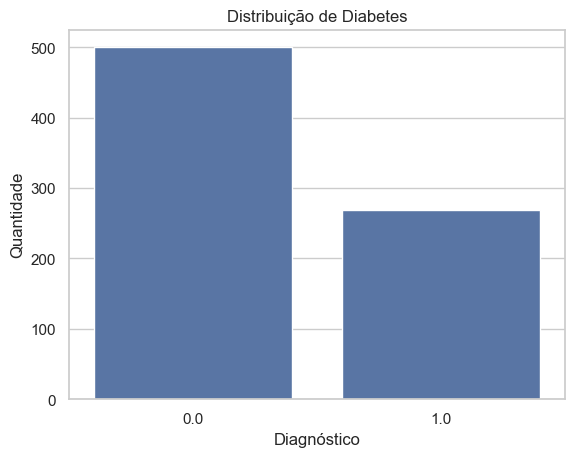

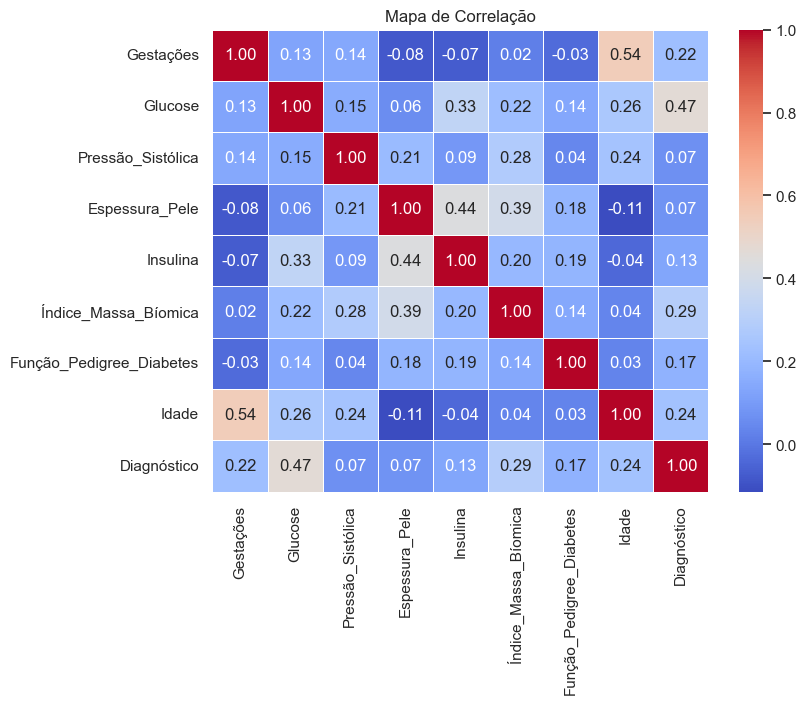

In [15]:
# --------------------------------------------------------------
# 1. Estatísticas descritivas
# --------------------------------------------------------------
display(df.describe())

# --------------------------------------------------------------
# 2. # Distribuição da classe alvo (Diagnóstico)
# --------------------------------------------------------------
sns.countplot(x='Diagnóstico', data=df)          # sem palette
plt.title('Distribuição de Diabetes')
plt.xlabel('Diagnóstico')      # opcional: deixa o rótulo mais claro
plt.ylabel('Quantidade')
plt.show()



# --------------------------------------------------------------
# 3. Correlações (matriz de correlação)
# --------------------------------------------------------------
corr = df.corr()                    # agora usa as colunas em português

plt.figure(figsize=(8,6))
sns.heatmap(corr,
            annot=True,
            cmap='coolwarm',
            fmt='.2f',              # exibe até 2 casas decimais
            linewidths=.5)          # separa as células para melhor visualização
plt.title('Mapa de Correlação')
plt.show() 




In [19]:
# Verifica se há NaNs na coluna alvo
print(df['Diagnóstico'].isna().sum())   # número de missing values

# Se houver, removemos as linhas correspondentes
df_clean = df.dropna(subset=['Diagnóstico'])

# Atualizamos X e y
X = df_clean.drop(columns=['Diagnóstico'])
y = df_clean['Diagnóstico']

from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"Shape X_train: {X_train.shape}")
print(f"Shape X_val  : {X_val.shape}")




1
Shape X_train: (614, 8)
Shape X_val  : (154, 8)


In [20]:
# ---------------------------------------------
# 1️⃣ Normalizar as features (StandardScaler)
# ---------------------------------------------
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)   # ajusta apenas no treino
X_val_scaled   = scaler.transform(X_val)         # aplica o mesmo ajuste

# Convertendo de volta a DataFrame para facilitar visualizações (opcional)
X_train_df  = pd.DataFrame(X_train_scaled, columns=X.columns,
                           index=X_train.index)
X_val_df    = pd.DataFrame(X_val_scaled,   columns=X.columns,
                           index=X_val.index)

print("Primeira linha do X_train escalonado:")
display(X_train_df.head())



Primeira linha do X_train escalonado:


,Gestações,Glucose,Pressão_Sistólica,Espessura_Pele,Insulina,Índice_Massa_Bíomica,Função_Pedigree_Diabetes,Idade
354,-0.851355,-1.056427,-0.826740,-1.918187,-1.203361,-0.769477,0.310794,-0.792169
712,0.356576,0.144399,0.477772,-0.229874,-1.470195,-0.417498,-0.116439,0.561034
374,-0.549372,-0.556083,-1.152868,1.233330,-0.555335,0.359790,-0.764862,-0.707594
47,-0.851355,0.811525,-1.315932,-0.004766,-0.161437,-0.402832,0.262314,-0.369293
683,-1.153338,-0.889646,-0.663676,1.120776,-0.415565,1.782373,-0.337630,-0.961320


In [21]:
# ---------------------------------------------
# 1️⃣ Importar os classificadores que vamos testar
# ---------------------------------------------
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

classifiers = {
    "Regressão Logística": LogisticRegression(max_iter=2000, random_state=42),
    "Árvore de Decisão": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=300,
                                            max_depth=None,
                                            min_samples_split=2,
                                            min_samples_leaf=1,
                                            random_state=42,
                                            n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200,
                                                    learning_rate=0.05,
                                                    max_depth=3,
                                                    random_state=42),
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma='scale',
                     probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}



=== Regressão Logística ===
Acurácia : 0.7078
Precisão: 0.6000
Recall   : 0.5000
F1‑Score : 0.5455
AUC      : 0.8130

=== Árvore de Decisão ===
Acurácia : 0.6818
Precisão: 0.5532
Recall   : 0.4815
F1‑Score : 0.5149
AUC      : 0.6357

=== Random Forest ===
Acurácia : 0.7338
Precisão: 0.6444
Recall   : 0.5370
F1‑Score : 0.5859
AUC      : 0.8170

=== Gradient Boosting ===
Acurácia : 0.7597
Precisão: 0.6809
Recall   : 0.5926
F1‑Score : 0.6337
AUC      : 0.8315

=== SVM (RBF) ===
Acurácia : 0.7143
Precisão: 0.5962
Recall   : 0.5741
F1‑Score : 0.5849
AUC      : 0.7852

=== KNN ===
Acurácia : 0.7532
Precisão: 0.6600
Recall   : 0.6111
F1‑Score : 0.6346
AUC      : 0.7886

=== Melhor modelo segundo AUC: Gradient Boosting


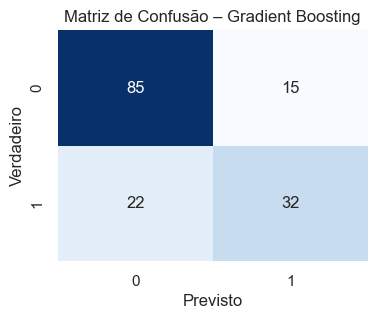

In [24]:
# ---------------------------------------------
# 1️⃣ Função de avaliação que retorna métricas básicas
# ---------------------------------------------
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def evaluate_model(clf, X_test, y_true):
    y_pred = clf.predict(X_test)
    
    acc   = accuracy_score(y_true, y_pred)
    prec  = precision_score(y_true, y_pred)
    rec   = recall_score(y_true, y_pred)
    f1    = f1_score(y_true, y_pred)
    auc   = roc_auc_score(y_true, clf.predict_proba(X_test)[:,1]) if hasattr(clf, "predict_proba") else None
    
    cm    = confusion_matrix(y_true, y_pred)
    
    return {
        'acurácia' : acc,
        'precisão' : prec,
        'recall'   : rec,
        'f1_score' : f1,
        'auc'      : auc,
        'matriz_de_confusao': cm
    }

# ---------------------------------------------
# 2️⃣ Treinar e avaliar cada modelo
# ---------------------------------------------
results = {}
for name, model in classifiers.items():
    print(f"\n=== {name} ===")
    
    # Treinamento
    model.fit(X_train_scaled, y_train)
    
    # Avaliação no conjunto de validação
    res = evaluate_model(model, X_val_scaled, y_val)
    
    results[name] = res
    
    # Exibir métricas
    print(f"Acurácia : {res['acurácia']:.4f}")
    print(f"Precisão: {res['precisão']:.4f}")
    print(f"Recall   : {res['recall']:.4f}")
    print(f"F1‑Score : {res['f1_score']:.4f}")
    if res['auc'] is not None:
        print(f"AUC      : {res['auc']:.4f}")

# ---------------------------------------------
# 3️⃣ Exibir matriz de confusão para o melhor modelo (por AUC)
# ---------------------------------------------
best_model_name = max(results, key=lambda k: results[k]['auc'])
print("\n=== Melhor modelo segundo AUC:", best_model_name)

cm = results[best_model_name]['matriz_de_confusao']
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            ax=ax)
ax.set_xlabel('Previsto')
ax.set_ylabel('Verdadeiro')
ax.set_title(f'Matriz de Confusão – {best_model_name}')
plt.show()
